In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import re
import unicodedata
import time
import io

import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Layer, GRU, Dense, Embedding, Activation, Bidirectional
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.metrics import Metric
from keras.optimizers import Adam

import matplotlib.ticker as ticker
from transformers import BertTokenizer, AutoTokenizer
from parsivar import Normalizer
import tensorflow_text as tf_text 
from keras.layers import TextVectorization

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


device = tf.config.experimental.list_physical_devices('GPU')[0]
print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
en_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
fa_tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

/home/alireza/miniconda3/envs/tf15/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
def create_dataset(file_path, num_examples=None):
    en_fa = []
    cnt = 0
    fa_normalizer = Normalizer()
    with open(file_path, 'r') as file:
        for line in file.readlines():
            if num_examples is not None and cnt >= num_examples: break
            line = line.split('\t')[:2]
            en = line[0]
            fa = fa_normalizer.normalize(line[1])
            fa = re.sub('\u200c', ' ', fa)
            en_fa.append([en, fa])
            cnt += 1
            if cnt % 100 == 0:
                print(f'\rRead {cnt:>5}', end='')

    print('\nRead', cnt)
    return zip(*en_fa)


def sort_dataset(source, target):
    xy = sorted(zip(source, target), key=lambda x: (len(x[0].split(' ')), len(x[1].split(' ')))) 
    x = [x[0] for x in xy]
    y = [y[1] for y in xy]
    return x, y

In [4]:
NUM_SAMPLES = 1_000_000
FILE_PATH = './Data/combined.txt'
src_lang, targ_lang = create_dataset(FILE_PATH, NUM_SAMPLES)

Read 994200
Read 994267


In [5]:
src_train, src_val, targ_train, targ_val = train_test_split(src_lang, targ_lang, test_size=0.2, shuffle=True, random_state=123)
src_train, targ_train = sort_dataset(src_train, targ_train)
src_val, targ_val = sort_dataset(src_val, targ_val)
print('Source Train examples:', len(src_train))
print('Source Validation examples:', len(src_val))

Source Train examples: 795413
Source Validation examples: 198854


In [6]:
i = -1
print('Training Example (English)')
print(src_val[i])

print('Training Example (Persian)')
print(targ_val[i])

Training Example (English)
He also admitted that you had some interest in a mill or mills we did not press him on this, being most upset at this information which was news to us that necessitated your riding about alone, or attended by a ruffian who, Captain Butler assures us, is a murderer.
Training Example (Persian)
او همچنین اعتراف کرد که شما به یک آسیاب یا آسیاب علاقه داشتید ، ما او را در این مورد تحت فشار قرار ندادیم ، زیرا از این اطلاعات که برای ما خبری بود که باعث می شد شما به تنهایی سوار شوید ، یا با حضور یک رفیق که ، کاپیتان باتلر به ما اطمینان می دهد ، بسیار ناراحت بودیم . ، یک قاتل است .


In [7]:
def en_vectorization(text):
    text = [x.decode('utf-8') for x in text.numpy()]
    return en_tokenizer(text, padding=True, return_tensors='tf')['input_ids']

def fa_vectorization(text):
    text = [x.decode('utf-8') for x in text.numpy()]
    return fa_tokenizer(text, padding=True, return_tensors='tf')['input_ids']

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
STEPS_PER_EPOCH = len(src_train) // BATCH_SIZE
BUFFER_SIZE = 1000

def preprocess(src, targ):
    src = tf.py_function(func=en_vectorization, inp=[src], Tout=tf.TensorSpec(shape=(None, None), dtype=tf.int32))
    src = tf.cast(src, tf.int32)
    targ = tf.py_function(func=fa_vectorization, inp=[targ], Tout=tf.TensorSpec(shape=(None, None), dtype=tf.int32))
    targ = tf.cast(targ, tf.int32)
    return src, targ

train_ds = tf.data.Dataset.from_tensor_slices((src_train, targ_train))
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
train_ds = train_ds.map(preprocess,
                       num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(STEPS_PER_EPOCH)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((src_val, targ_val))
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(AUTOTUNE)

In [9]:
for example_train_source, example_train_target in train_ds.skip(0).take(20):
    print('Example Train Source:', example_train_source.shape)
    print('Example Train Target:', example_train_target.shape)
    print()

Example Train Source: (128, 28)
Example Train Target: (128, 29)

Example Train Source: (128, 11)
Example Train Target: (128, 8)

Example Train Source: (128, 17)
Example Train Target: (128, 10)

Example Train Source: (128, 20)
Example Train Target: (128, 17)

Example Train Source: (128, 28)
Example Train Target: (128, 29)

Example Train Source: (128, 33)
Example Train Target: (128, 32)

Example Train Source: (128, 18)
Example Train Target: (128, 19)

Example Train Source: (128, 15)
Example Train Target: (128, 8)

Example Train Source: (128, 25)
Example Train Target: (128, 24)

Example Train Source: (128, 14)
Example Train Target: (128, 13)

Example Train Source: (128, 28)
Example Train Target: (128, 26)

Example Train Source: (128, 39)
Example Train Target: (128, 36)

Example Train Source: (128, 10)
Example Train Target: (128, 8)

Example Train Source: (128, 17)
Example Train Target: (128, 16)

Example Train Source: (128, 10)
Example Train Target: (128, 11)

Example Train Source: (128, 

In [10]:
for i in range(BATCH_SIZE):
    print('EXAMPLE English:', en_tokenizer.decode(example_train_source[i]))
    print('EXAMPLE Farsi:', fa_tokenizer.decode(example_train_target[i]))
    print()

EXAMPLE English: [CLS] stop him someone stop him. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] متوقفش کن کسی او را متوقف کند.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

EXAMPLE English: [CLS] and your mother called.'' thank you.'[SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] و مادرت زنگ زد.'متشکرم.'[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

EXAMPLE English: [CLS] she probably just got it wrong. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] احتمالا تو رو با کس دیگه اشتباه گرفته[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

EXAMPLE English: [CLS] there's no occasion to pick'em ; [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] فرصتی برای انتخاب آن ها وجود ندارد.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

EXAMPLE English: [CLS] something that happens to most people [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [49]:
SOURCE_VOCAB_SIZE = len(en_tokenizer.get_vocab())
TARGET_VOCAB_SIZE = len(fa_tokenizer.get_vocab())
ENCODER_UNITS = 64
DECODER_UNITS = 128
EMBD_DIM = 128
ATTENTION_UNITS = 10

In [26]:
class Encoder(Model):
    def __init__(self, rnn_units, vocab_size, embd_dim, batch_size):
      super(Encoder, self).__init__()
      self.rnn_units = rnn_units
      self.batch_size = batch_size
      self.embedding = Embedding(vocab_size, embd_dim)
      self.gru = Bidirectional(GRU(
            units=rnn_units,
            return_sequences=True,
            return_state=True
        ))
      self.initialize_state()

    def build(self):
        inputs = keras.layers.Input(shape=(None,))
        self.call(inputs)
        self.built = True
    
    def call(self, inputs, initial_state=None):
      if initial_state is not None:
          self._hidden = initial_state[0]
          self._backward_hidden = initial_state[1]
    
      x = self.embedding(inputs)
      sequences, h, bh = self.gru(x, initial_state=(self._hidden, self._backward_hidden))
    
      return sequences, (h, bh)
    
    
    def get_hidden_states(self):
      return self._hidden, self._backward_hidden
    
    def initialize_state(self):
      self._hidden = tf.zeros((self.batch_size, self.rnn_units))
      self._backward_hidden = tf.zeros((self.batch_size, self.rnn_units))
      return self.get_hidden_states()


In [29]:
encoder = Encoder(ENCODER_UNITS, SOURCE_VOCAB_SIZE, EMBD_DIM, BATCH_SIZE)
encoder.build()
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(output_sample.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(state_sample[0].shape))
encoder.summary()

Encoder output shape: (batch size, sequence length, units) (128, 20, 128)
Encoder Hidden state shape: (batch size, units) (128, 64)
Model: "encoder_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         3906816   
                                                                 
 bidirectional_5 (Bidirecti  [(128, None, 128),        74496     
 onal)                        (128, 64),                         
                              (128, 64)]                         
                                                                 
Total params: 3981312 (15.19 MB)
Trainable params: 3981312 (15.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
class BahdanauAttention(Model):
  def __init__(self, units):
      super(BahdanauAttention, self).__init__()
      self.w1 = Dense(units)
      self.w2 = Dense(units)
      self.v = Dense(1)

  def call(self, sequences, s_prev):
      s_prev = tf.expand_dims(s_prev, 1)
      x = self.v(tf.nn.tanh(self.w1(sequences) + self.w2(s_prev)))
      attention_weights = tf.nn.softmax(x, axis=1)
      context = sequences * attention_weights
      context = tf.reduce_sum(context, axis=1)

      return context, attention_weights

In [31]:
attention = BahdanauAttention(ATTENTION_UNITS)
context, attention_weights = attention(output_sample, state_sample[0])

print("Attention result shape: (batch size, units) {}".format(context.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 128)
Attention weights shape: (batch_size, sequence_length, 1) (128, 20, 1)


In [54]:
class Decoder(Model):
    def __init__(self, rnn_units, attention_units, vocab_size, embd_dim):
        super(Decoder, self).__init__()
        self.rnn_units = rnn_units
        self.embedding = Embedding(vocab_size, embd_dim)
        self.gru = GRU(rnn_units, return_sequences=True, return_state=True)
        self.attention = BahdanauAttention(attention_units)
        self.fc = Dense(vocab_size)
        
    
    def call(self, inputs, sequences, s_prev):
      x = self.embedding(inputs)
    
      context, attention_weights = self.attention(sequences, s_prev)
      context = tf.expand_dims(context, 1)
      x = tf.concat([context, x], axis=-1)
      output, state = self.gru(x, s_prev)
      output = tf.reshape(output, (-1, output.shape[2]))
      output = self.fc(output)
    
      return output, state, attention_weights

In [55]:
decoder = Decoder(DECODER_UNITS, ATTENTION_UNITS, TARGET_VOCAB_SIZE, EMBD_DIM)
hidden = tf.concat([state_sample[0], state_sample[1]], axis=-1)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      output_sample, hidden)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
decoder.summary()

Decoder output shape: (batch_size, vocab size) (128, 25001)
Model: "decoder_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    multiple                  3200128   
                                                                 
 gru_17 (GRU)                multiple                  148224    
                                                                 
 bahdanau_attention_13 (Bah  multiple                  2591      
 danauAttention)                                                 
                                                                 
 dense_53 (Dense)            multiple                  3225129   
                                                                 
Total params: 6576072 (25.09 MB)
Trainable params: 6576072 (25.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
encoder = Encoder(ENCODER_UNITS, SOURCE_VOCAB_SIZE, EMBD_DIM, BATCH_SIZE)
decoder = Decoder(DECODER_UNITS, ATTENTION_UNITS, TARGET_VOCAB_SIZE, EMBD_DIM)

In [19]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam()

class MaskedAccuracy(Metric):
    def __init__(self, name='masked_accuracy', **kwargs):
        super(MaskedAccuracy, self).__init__(name=name, **kwargs)

        self.total = self.add_weight(name='total', 
                                     shape=(), 
                                     dtype='float32', 
                                     initializer='zeros')
        
        self.count = self.add_weight(name='count', 
                                     shape=(), 
                                     dtype='float32', 
                                     initializer='zeros')


    def update_state(self, y_true, pred, sample_weights=None):
        # pred = [B, dec_seq_len, target_vocab_size]
        # y_true = [B, dec_seq_len]
        y_pred = tf.argmax(pred, axis=-1)
        y_pred = tf.cast(y_pred, y_true.dtype)
        mask = tf.logical_not(tf.equal(y_true, fa_tokenizer.pad_token_id))

        match = tf.equal(y_pred, y_true)
        match = tf.logical_and(match, mask)

        match = tf.cast(match, tf.float32)
        mask = tf.cast(mask, tf.float32)

        self.total.assign_add(tf.reduce_sum(match))
        self.count.assign_add(tf.reduce_sum(mask))


    def result(self):
        return self.total / self.count if self.count != 0 else 0

    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
        
def loss_func(real, pred):
    # Make a mask that is 1 everywhere there is not a padding, and 0 for paddings
    mask = tf.math.logical_not(tf.math.equal(real, fa_tokenizer.pad_token_id))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [20]:
training_accuracy = MaskedAccuracy(name='train_acc')
test_accuracy = MaskedAccuracy(name='valid_acc')

In [21]:
def get_scheduler(d_model, warmup_steps=4000):
    def get_learning_rate(step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * tf.math.pow(warmup_steps * 1.0, -1.5)

        return tf.math.rsqrt(d_model * 1.0) * tf.minimum(arg1, arg2)

    return get_learning_rate

In [22]:
EPOCHS = 30
scheduler = get_scheduler(EMBD_DIM, warmup_steps=int(0.10 * STEPS_PER_EPOCH * EPOCHS))
optimizer = Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_acc = MaskedAccuracy(name='train_acc')
valid_acc = MaskedAccuracy(name='valid_acc')

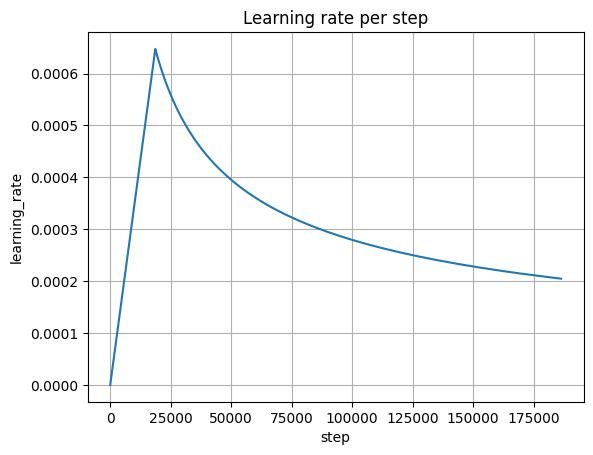

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(STEPS_PER_EPOCH * EPOCHS), scheduler(np.arange(STEPS_PER_EPOCH * EPOCHS)));
ax.grid();
ax.set_title('Learning rate per step');
ax.set_xlabel('step')
ax.set_ylabel('learning_rate');

In [24]:
print('Loading cache...')
for i, (x, y) in enumerate(train_ds): 
    print(f'\r{i:>5}', end='')
print()
for i, (x, y) in enumerate(test_ds): 
    print(f'\r{i:>5}', end='')
print()

Loading cache...
 6213
 1552


In [25]:
inp_signature = tf.TensorSpec(shape=(None, None), dtype=tf.int32)
targ_signature = tf.TensorSpec(shape=(None, None), dtype=tf.int32)
hidden_signature = [tf.TensorSpec(shape=(BATCH_SIZE, ENCODER_UNITS), dtype=tf.float32)]

@tf.function(reduce_retracing=True)
def train_step(inp, targ, hidden):
    loss = 0.0
    with tf.GradientTape() as tape:
        enc_output, (enc_h, enc_bh) = encoder(inp, hidden)
        dec_hidden = tf.concat([enc_h, enc_bh], axis=-1)
        dec_inputs = tf.expand_dims([fa_tokenizer.cls_token_id] * BATCH_SIZE, 1)

        for t in range(1, tf.shape(targ)[1]):
            dec_outputs, dec_hidden, _ = decoder(dec_inputs, enc_output, dec_hidden, training=True)
            computed_loss = loss_func(targ[:, t], dec_outputs)
            loss = loss + computed_loss
            dec_inputs = tf.expand_dims(targ[:, t], 1)
            training_accuracy.update_state(targ[:, t], dec_outputs)


    batch_loss = loss / tf.cast(tf.shape(targ)[1], tf.float32)
    variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return batch_loss

In [26]:
@tf.function(reduce_retracing=True)
def test_step(inp, targ, hidden):
    loss = 0.0
    enc_output, (enc_h, enc_bh) = encoder(inp, hidden, training=False)
    dec_hidden = tf.concat([enc_h, enc_bh], axis=-1)
    dec_inputs = tf.expand_dims([fa_tokenizer.cls_token_id] * BATCH_SIZE, 1)

    for t in range(1, tf.shape(targ)[1]):
        dec_outputs, dec_hidden, _ = decoder(dec_inputs, enc_output, dec_hidden, training=False)
        computed_loss = loss_func(targ[:, t], dec_outputs)
        loss = loss + computed_loss
        dec_inputs = tf.expand_dims(targ[:, t], 1)
        test_accuracy.update_state(targ[:, t], dec_outputs)

    batch_loss = loss / tf.cast(tf.shape(targ)[1], tf.float32)

    return batch_loss

In [27]:
train_writer = tf.summary.create_file_writer(logdir='./logs/RNN/train')
test_writer = tf.summary.create_file_writer(logdir='./logs/RNN/test')

In [28]:
train_mean_losses = []
train_accs = []
valid_mean_losses = []
valid_accs = []
total_steps = 0

for epoch in range(EPOCHS):
    training_accuracy.reset_state()
    test_accuracy.reset_state()
    train_mean_loss = 0
    valid_mean_loss = 0
    hidden = encoder.initialize_state()
    start = time.time()
    
    print(f"epoch {epoch + 1}:\n")
    for step, (source, target) in enumerate(train_ds):
        optimizer.learning_rate = scheduler(total_steps)
        loss = train_step(source, target, hidden)
        train_acc = training_accuracy.result()
        train_mean_loss = train_mean_loss + (1 / (step + 1)) * (loss - train_mean_loss)
        end = time.time()

        print(f'\r{int(end - start):>4} sec | Step {step + 1:>5}\tloss: {train_mean_loss:>4.3f} \taccuracy: {train_acc:>4.3f}', end='')
        
        with train_writer.as_default():
            tf.summary.scalar('Loss_Per_Step', train_mean_loss, step=total_steps)
            tf.summary.scalar('Accuracy_Per_Step', train_acc, step=total_steps)
        total_steps += 1
            
    print()
    train_mean_losses.append(train_mean_loss)
    train_accs.append(train_acc)

    with train_writer.as_default():
        tf.summary.scalar('Loss_Per_Epoch', train_mean_loss, step=epoch)
        tf.summary.scalar('Accuracy_Per_Epoch', train_acc, step=epoch)
    
    for step, (source, target) in enumerate(test_ds):
        loss = test_step(source, target, hidden)
        test_acc = test_accuracy.result()
        valid_mean_loss = valid_mean_loss + (1 / (step + 1)) * (loss - valid_mean_loss)
        end = time.time()

        print(f'\r{int(end - start):>4} sec | Step {step + 1:>5}\tloss: {valid_mean_loss:>4.3f} \taccuracy: {test_acc:>4.3f}', end='')

    
    valid_mean_losses.append(valid_mean_loss)
    valid_accs.append(test_acc)

    with test_writer.as_default():
        tf.summary.scalar('Loss_Per_Epoch', valid_mean_loss, step=epoch)
        tf.summary.scalar('Accuracy_Per_Epoch', test_acc, step=epoch)


    encoder.save_weights(f'./Checkpoints/RNN/Encoder/{epoch}.h5')
    decoder.save_weights(f'./Checkpoints/RNN/Decoder/{epoch}.h5')
    print('\n')


epoch 1:



W0000 00:00:1719267924.812598  112292 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2060" frequency: 1560 num_cores: 30 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 3145728 shared_memory_size_per_multiprocessor: 65536 memory_size: 5021040640 bandwidth: 264048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
I0000 00:00:1719267926.361543  112473 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   6 sec | Step     1	loss: 7.944 	accuracy: 0.000

W0000 00:00:1719267929.126881  112292 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2060" frequency: 1560 num_cores: 30 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 3145728 shared_memory_size_per_multiprocessor: 65536 memory_size: 5021040640 bandwidth: 264048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1575 sec | Step  6214	loss: 4.174 	accuracy: 0.105
1862 sec | Step  1553	loss: 3.294 	accuracy: 0.180

epoch 2:

1494 sec | Step  6214	loss: 2.997 	accuracy: 0.247
1779 sec | Step  1553	loss: 2.674 	accuracy: 0.308

epoch 3:

1495 sec | Step  6214	loss: 2.388 	accuracy: 0.369
1780 sec | Step  1553	loss: 2.098 	accuracy: 0.422

epoch 4:

1495 sec | Step  6214	loss: 1.898 	accuracy: 0.459
1780 sec | Step  1553	loss: 1.724 	accuracy: 0.490

epoch 5:

1495 sec | Step  6214	loss: 1.616 	accuracy: 0.515
1780 sec | Step  1553	loss: 1.547 	accuracy: 0.529

epoch 6:

1496 sec | Step  6214	loss: 1.456 	accuracy: 0.549
1781 sec | Step  1553	loss: 1.456 	accuracy: 0.549

epoch 7:

1500 sec | Step  6214	loss: 1.357 	accuracy: 0.572
1785 sec | Step  1553	loss: 1.371 	accuracy: 0.566

epoch 8:

1496 sec | Step  6214	loss: 1.288 	accuracy: 0.589
1781 sec | Step  1553	loss: 1.324 	accuracy: 0.578

epoch 9:

1497 sec | Step  6214	loss: 1.234 	accuracy: 0.602
1782 sec | Step  1553	loss: 1.291 	accuracy: 

## Translator

In [282]:
encoder.load_weights('./Checkpoints/RNN/Encoder/29.h5')
decoder.load_weights('./Checkpoints/RNN/Decoder/29.h5')

In [332]:
class GreedyTranslator(tf.Module):
    def __init__(self, encoder, decoder, fa_tokenizer, *, max_length=50, return_attention_weights=False):
        super(GreedyTranslator, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.fa_tokenizer = fa_tokenizer
        self.max_length = max_length
        self.start_token = fa_tokenizer.cls_token_id
        self.end_token = fa_tokenizer.sep_token_id
        self.pad_token = fa_tokenizer.pad_token_id
        self.return_attention_weights = return_attention_weights

    @tf.function(input_signature=[tf.TensorSpec(shape=(None, None), dtype=tf.int32)])
    def __call__(self, tokenized_sentence):
        batch_size = tf.shape(tokenized_sentence)[0]
        seqs, (h, bh) = encoder(tokenized)
        s_prev = tf.concat([h, bh], axis=-1)
        
        dec_inp_arr = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        dec_inp_arr = dec_inp_arr.write(0, tf.fill([batch_size], self.start_token))
        not_finished = tf.ones((batch_size,), tf.float32)
        attention_weights_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        
        for i in tf.range(self.max_length):
            dec_inp = tf.transpose(dec_inp_arr.stack())
            dec_inp = tf.expand_dims(dec_inp[:, -1], axis=-1)
            output, s_prev, attention_weights = decoder(dec_inp, seqs, s_prev, training=False)
            attention_weights_arr = attention_weights_arr.write(i, attention_weights[0, :, 0])
            output = tf.argmax(output, axis=-1)
            output = tf.cast(output, tf.float32)
            not_seen_end = tf.cast(tf.logical_not(tf.equal(output, self.end_token)), tf.float32)
            not_finished = not_seen_end * not_finished
            output = output * not_finished + (1 - not_finished) * self.pad_token

            output = tf.cast(output, tf.int32)
            dec_inp_arr = dec_inp_arr.write(i + 1, output[:])
        
            if tf.reduce_sum(not_finished) == 0:
                break

        outputs = tf.transpose(dec_inp_arr.stack())
        decoder_input_array = dec_inp_arr.close()

        if self.return_attention_weights:
            attentions = attention_weights_arr.stack()
            attention_weights_arr = attention_weights_arr.close()
            return outputs, attentions

        return outputs

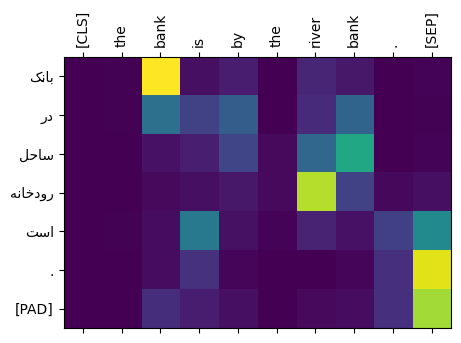

In [336]:
from bidi.algorithm import get_display
import arabic_reshaper

greedyTranslator = GreedyTranslator(encoder, decoder, fa_tokenizer, max_length=100, return_attention_weights=True)

sentence = 'The bank is by the river bank.'
tokenized = en_tokenizer.encode(sentence, add_special_tokens=True)
tokenized = tf.expand_dims(tokenized, axis=0)
result, attention_scores = greedyTranslator(tokenized)
result = result.numpy()[0, 1:]

x_tick_labels = [en_tokenizer.decode([i]) for i in tokenized[0]]
y_tick_labels = [get_display(arabic_reshaper.reshape(fa_tokenizer.decode([i]))) for i in result]

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
ax.matshow(attention_scores[:, :])
ax.set_xticks(range(len(x_tick_labels)))
ax.set_yticks(range(len(y_tick_labels)));
ax.set_xticklabels(x_tick_labels, rotation=90);
ax.set_yticklabels(y_tick_labels);

fig.savefig('./figures/RNN/attention_weights3.png', dpi=320)